##### Даны два файла data.csv и verify.csv. Разделитель – ';'

Поля: ID – уникальный айди записи, feature_1 … feature_124 – признаки.

В файле data.csv также присутствует target, принимающий два значения – 0 или 1

### 1.Задание

1.1.Решите задачу двухклассовой классификации, обучив модель на данных в data.csv После обучения вы должны получить вероятность принадлежности каждого объекта к таргет, равному единице 1.

1.2.Сгруппируйте выборку по значениям вероятности с шагом 0.1, и в каждой группе посчитайте: сколько объектов в группе, сколько в группе объектов с target = 1.

1.3.Посчитайте метрики модели (F-мера, коэффициент джини и другие) на данных из data.csv

1.4.С помощью полученной модели определите вероятность принадлежности к таргет 1 каждого объекта из verify.csv. 

1.5.Запишите полученные предсказания в csv-файл (разделитель – точка с запятой). В файле должны быть два поля: ID – айди который задан в файле verify.csv и score – вероятность которую вы получили для данного ID.

##### Таким образом, по результатам задания вы должны получить:

• метрики модели на данных из data.csv

• таблицу с группировкой

• файл с предсказаниями на данных из файла verify.csv 

• записки/текстовые файлы с кратким описанием хода обучения

Необходимо использовать логистическую регрессию. Если есть желание, дополнительно можете прислать результаты любой другой модели, если считаете, что она лучше.


### 2. Вопросы

Ответьте на следующие вопросы:
___
___
• Как можно заполнить пропущенные значения в данных?

Пропущенные значения можно заполнить исходя из данных. Большое количество отсутствующих данных в признаке чаще всего позволяет этот признак удалить. Некоторые признаки могут быть взаимосвязаны с другими признаками, тогда можно заполнить данными на основе этих признаков. Самый простой вариант, если в признаке не очень много отсутствующих данных, заполнить средними значениями.
___
___
• Что делать, если таргет несбалансированный?

Можно использовать сбалансированный режим, параметр в модели алгоритма.
___
___
• Как бороться с переобучением?

Можно использовать параметры регуляризации данных в модели алгоритма. Перекрестная проверка. Удалить лишние признаки, плохо влияющие на модель.
___
___
• Найдите потенциальные причины аномалий в наборе данных.

В предоставленных данных, причинами аномалий могут быть выбросы. Слишком высокие или низкие значения отклоняющиеся от большинства значений. Но т к деталей по признакам нет, трудно сказать, можно ли считать это аномалиями. Возможно такие данные имеют место быть.
___
___
• Что делать, если данных не хватает или они плохого качества?

Если данных не хватает, нужно попробовать их найти и добавить. Либо можно создать новые признаки на основе имеющихся признаков. Если данные плохого качества, к примеру с выбросами, нужно разбираться в природе этих выбросов. Имеет ли это место быть или нет. Если совсем плохое качество и нельзя это решить, то лучше удалить такой признак.
___
___
• Что можно сделать чтобы повысить качество?

Разведочный анализ данных (EDA). Визуализация данных. 

Бороться с выбросами. Удалить ненужные признаки. Создать новые признаки на основе имеющихся, которые действительно могут помочь. Сделать признак на основе целевого признака. Заполнить отсутствующие данные в признаках. 

Перевести признаки в нужный тип данных. К примеру числовые строки в числа. Перевести номинативные данные в категориальные или бинарные. Мужчина, женщина в 0, 1. Или сделать фиктивные признаки, разбить признак на несколько признаков бинарных.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
verify = pd.read_csv('verify.csv', sep=';')

In [3]:
data = pd.read_csv('data.csv', sep=';')

### EDA

In [4]:
verify.info()
print('_'*40)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56030 entries, 0 to 56029
Columns: 125 entries, ID to feature_124
dtypes: float64(21), int64(104)
memory usage: 53.4 MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255820 entries, 0 to 255819
Columns: 126 entries, ID to target
dtypes: float64(21), int64(105)
memory usage: 245.9 MB


Данные синхронно отсутствуют, как в обучающем так и в тестовом наборе данных в одинаковых признаках.

In [5]:
print(verify.isnull().sum()[100:110])
print('_'*40)
print(data.isnull().sum()[100:110])

feature_100        0
feature_101        0
feature_102    11459
feature_103    11459
feature_104    11459
feature_105    11459
feature_106    12960
feature_107        0
feature_108        0
feature_109        0
dtype: int64
________________________________________
feature_100        0
feature_101        0
feature_102    37795
feature_103    37795
feature_104    37795
feature_105    37795
feature_106    41893
feature_107        0
feature_108        0
feature_109        0
dtype: int64


В данных несбалансированный целевой признак.

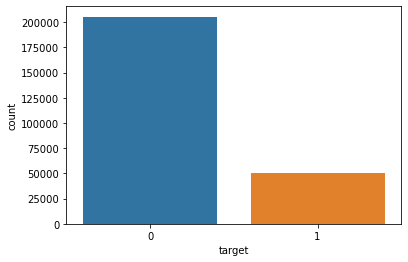

In [6]:
sns.countplot(data=data, x='target');

In [7]:
print("Процент target = 0:")
round(len(data[data['target']==0]) / len(data),2)

Процент target = 0:


0.8

In [8]:
print("Процент target = 1:")
round(len(data[data['target']==1]) / len(data),2)

Процент target = 1:


0.2

##### Объединение тренировочного и тестового набора данных.
При работе с отсутствующими значениями удобно работать с объединенным тренировочным и тестовым набором, иначе заполненные данные могут чрезмерно соответствовать образцам тренировочного или тестового набора.

In [9]:
y = data['target']

In [10]:
data['is_test'] = 0
verify['is_test'] = 1

In [11]:
df = pd.concat([data, verify]).reset_index(drop=True)

In [12]:
df

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target,is_test
0,1,1,0,0,1381,63,0,0,1,0,...,0,0,0.0,7000,4000,7526.3157,12000,0.583333,0.0,0
1,2,0,0,0,1809,33,1,0,1,0,...,0,0,0.0,10000,1000,8393.4426,30000,0.333333,0.0,0
2,3,0,0,0,1804,29,0,1,0,0,...,0,0,0.0,3000,1000,3425.9259,15000,0.200000,0.0,0
3,4,0,0,0,1560,28,1,1,0,0,...,0,0,0.0,2000,1000,1946.6666,3000,0.666667,0.0,0
4,5,0,0,0,258,33,1,0,0,0,...,0,0,0.0,2000,2000,4444.4444,8000,0.250000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311845,311846,0,0,0,58,27,0,0,1,0,...,0,0,0.0,3000,2500,3100.0000,4000,0.750000,NaN,1
311846,311847,1,0,0,131,28,0,0,1,0,...,0,0,0.0,12000,4000,8137.5000,12000,1.000000,NaN,1
311847,311848,0,0,0,199,32,0,0,1,0,...,1,2,0.2,30000,30000,30620.0000,36200,0.828729,NaN,1
311848,311849,0,0,0,904,56,1,1,0,0,...,0,0,0.0,2400,1000,3007.1428,10000,0.240000,NaN,1


##### Обработка пропущенных данных.

In [13]:
df.describe().transpose()[100:110]

,count,mean,std,min,25%,50%,75%,max
feature_100,311850.0,2.509078,3.900219,0.0,0.00000,1.000000,3.000000,131.000000
feature_101,311850.0,0.496499,0.483152,0.0,0.00000,0.400000,1.000000,1.000000
feature_102,262596.0,62.808028,205.657738,-490.0,3.00000,11.000000,34.000000,3467.000000
feature_103,262596.0,18.526927,131.308240,-948.0,0.00000,1.000000,5.000000,3467.000000
feature_104,262596.0,61.256672,155.342566,-153.0,11.00000,24.000000,52.000000,3467.000000
feature_105,262596.0,248.096974,372.295457,-81.0,34.00000,109.000000,291.000000,3467.000000
feature_106,256997.0,0.356809,0.502397,-76.6,0.03125,0.147668,0.795918,9.428571
feature_107,311850.0,0.083515,0.276659,0.0,0.00000,0.000000,0.000000,1.000000
feature_108,311850.0,1.057505,2.479724,0.0,0.00000,0.000000,1.000000,67.000000
feature_109,311850.0,0.062546,0.126045,0.0,0.00000,0.000000,0.071429,4.000000


In [14]:
print("Процент пропущенных значений в столбце feature_102:")
round(sum(df['feature_102'].isnull()) / len(df) *100, 2)

Процент пропущенных значений в столбце feature_102:


15.79

In [15]:
print("Процент пропущенных значений в столбце feature_103:")
round(sum(df['feature_103'].isnull()) / len(df) *100, 2)

Процент пропущенных значений в столбце feature_103:


15.79

In [16]:
print("Процент пропущенных значений в столбце feature_104:")
round(sum(df['feature_104'].isnull()) / len(df) *100, 2)

Процент пропущенных значений в столбце feature_104:


15.79

In [17]:
print("Процент пропущенных значений в столбце feature_105:")
round(sum(df['feature_105'].isnull()) / len(df) *100, 2)

Процент пропущенных значений в столбце feature_105:


15.79

In [18]:
print("Процент пропущенных значений в столбце feature_106:")
round(sum(df['feature_106'].isnull()) / len(df) *100, 2)

Процент пропущенных значений в столбце feature_106:


17.59

Т к подробные детали по данным отсутствуют и пропущенные данные составляют небольшой процент, заменяю их на среднее арифметическое по признаку.

In [19]:
df['feature_102'] =  df['feature_102'].fillna(df['feature_102'].mean())

In [20]:
df['feature_103'] =  df['feature_103'].fillna(df['feature_103'].mean())

In [21]:
df['feature_104'] =  df['feature_104'].fillna(df['feature_104'].mean())

In [22]:
df['feature_105'] =  df['feature_105'].fillna(df['feature_105'].mean())

In [23]:
df['feature_106'] =  df['feature_106'].fillna(df['feature_106'].mean())

##### Корреляция целевого признака.

Корреляция целевого признака target с другими значениями не превышает 0.2. Т е, какой либо сильной коррелляции здесь нет. И можно ориентироваться на коррелляцию признаков между собой.

In [24]:
corr_df = data.drop('ID', axis=1).corr()

In [25]:
target_corr = corr_df['target'].sort_values().iloc[0:-2]

In [26]:
target_corr.abs().sort_values(ascending=False)[0:10]

feature_114    0.229713
feature_110    0.225429
feature_83     0.210180
feature_88     0.194820
feature_85     0.193477
feature_113    0.190838
feature_2      0.189830
feature_52     0.188479
feature_86     0.188021
feature_55     0.177475
Name: target, dtype: float64

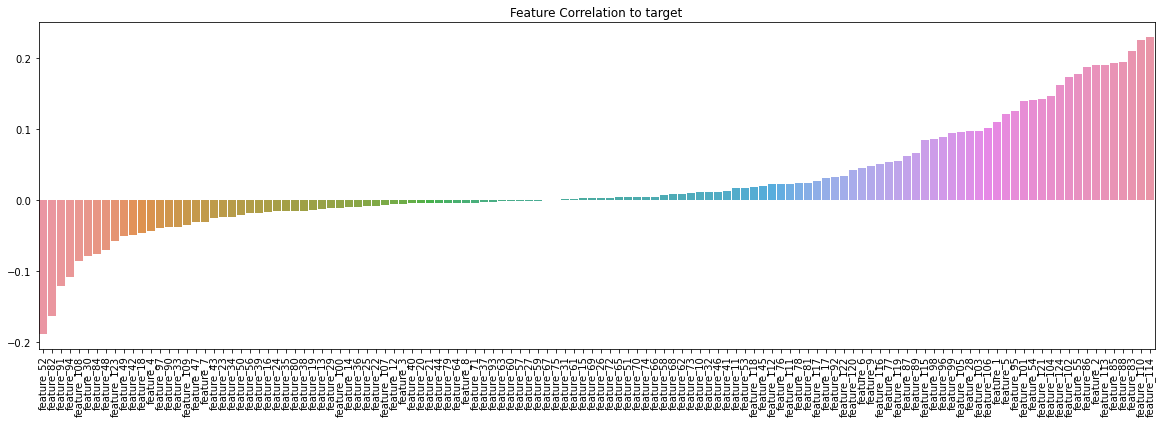

In [27]:
plt.figure(figsize=(20,6))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.title("Feature Correlation to target")
plt.xticks(rotation=90);

##### Корреляция признаков между собой.

In [28]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr.drop(df_corr.iloc[1::2].index, inplace=True)
df_corr_nd = df_corr.drop(df_corr[df_corr['Correlation Coefficient'] == 1.0].index)

Наблюдается мультиколинеарность в первых двух позициях. Это значит что, такие признаки повторяют друг друга. Можно удалять их. 

Также наблюдается сильная взаимосвязь между другими признаками.

In [29]:
corr = df_corr_nd['Correlation Coefficient'] > 0.5
df_corr_nd[corr][0:25]

,Feature 1,Feature 2,Correlation Coefficient
128,feature_111,feature_112,0.998409
130,feature_114,feature_110,0.985969
132,feature_80,feature_78,0.907659
134,feature_16,feature_13,0.855745
136,feature_117,feature_118,0.836672
138,feature_104,feature_103,0.829919
140,feature_97,feature_100,0.819616
142,feature_91,feature_94,0.803399
144,feature_49,feature_48,0.800668
146,feature_84,feature_97,0.790852


Отчетливо видно, что основные взаимосвязи скопились в правом нижнем углу на карте.

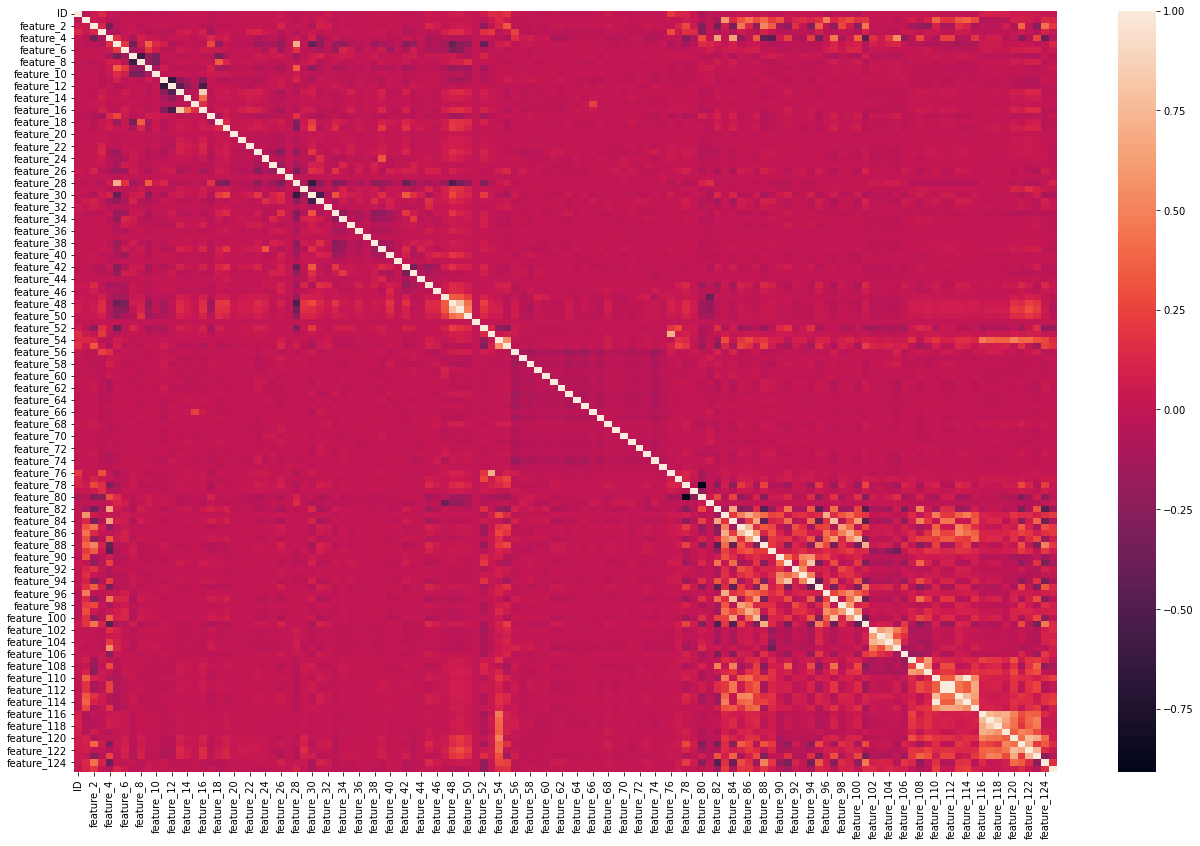

In [30]:
plt.figure(figsize=(22,14))
sns.heatmap(data=df.drop(['is_test'], axis=1).corr());

Оставляю признаки с высокой взаимосвязью.

In [31]:
df = df.drop(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5','feature_6', 'feature_7', 'feature_8', 
              'feature_9', 'feature_10','feature_11', 'feature_12', 'feature_14', 'feature_15','feature_17', 'feature_18', 
              'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
              'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 
              'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 
              'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 
              'feature_47', 'feature_50', 'feature_51', 'feature_52', 'feature_54', 'feature_55', 'feature_56', 
              'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 
              'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70',
              'feature_71', 'feature_72', 'feature_73', 'feature_74', 'feature_75', 'feature_77', 'feature_79',
              'feature_81', 'feature_82', 'feature_83', 'feature_88', 'feature_89', 'feature_90', 'feature_92', 
              'feature_93', 'feature_95', 'feature_96', 'feature_98', 'feature_101', 'feature_105', 'feature_106', 
              'feature_107', 'feature_108', 'feature_109', 'feature_115', 'feature_121', 'feature_124'], axis=1)

Удаляю признаки с мультиколлинеарностью, и близкие к ним.

In [32]:
df = df.drop(['feature_112', 'feature_110', 'feature_78', 'feature_13', 'feature_118', 'feature_103', 'feature_100', 
              'feature_94', 'feature_49'], axis=1)

Удаляю признаки, с низкими коэффициентами из итоговой модели по обучающей выборке.

In [33]:
df = df.drop(['feature_16', 'feature_53','feature_113'], axis=1)

Получилась интересная карта с сильными взаимосвязями признаков, а также целевого признака.

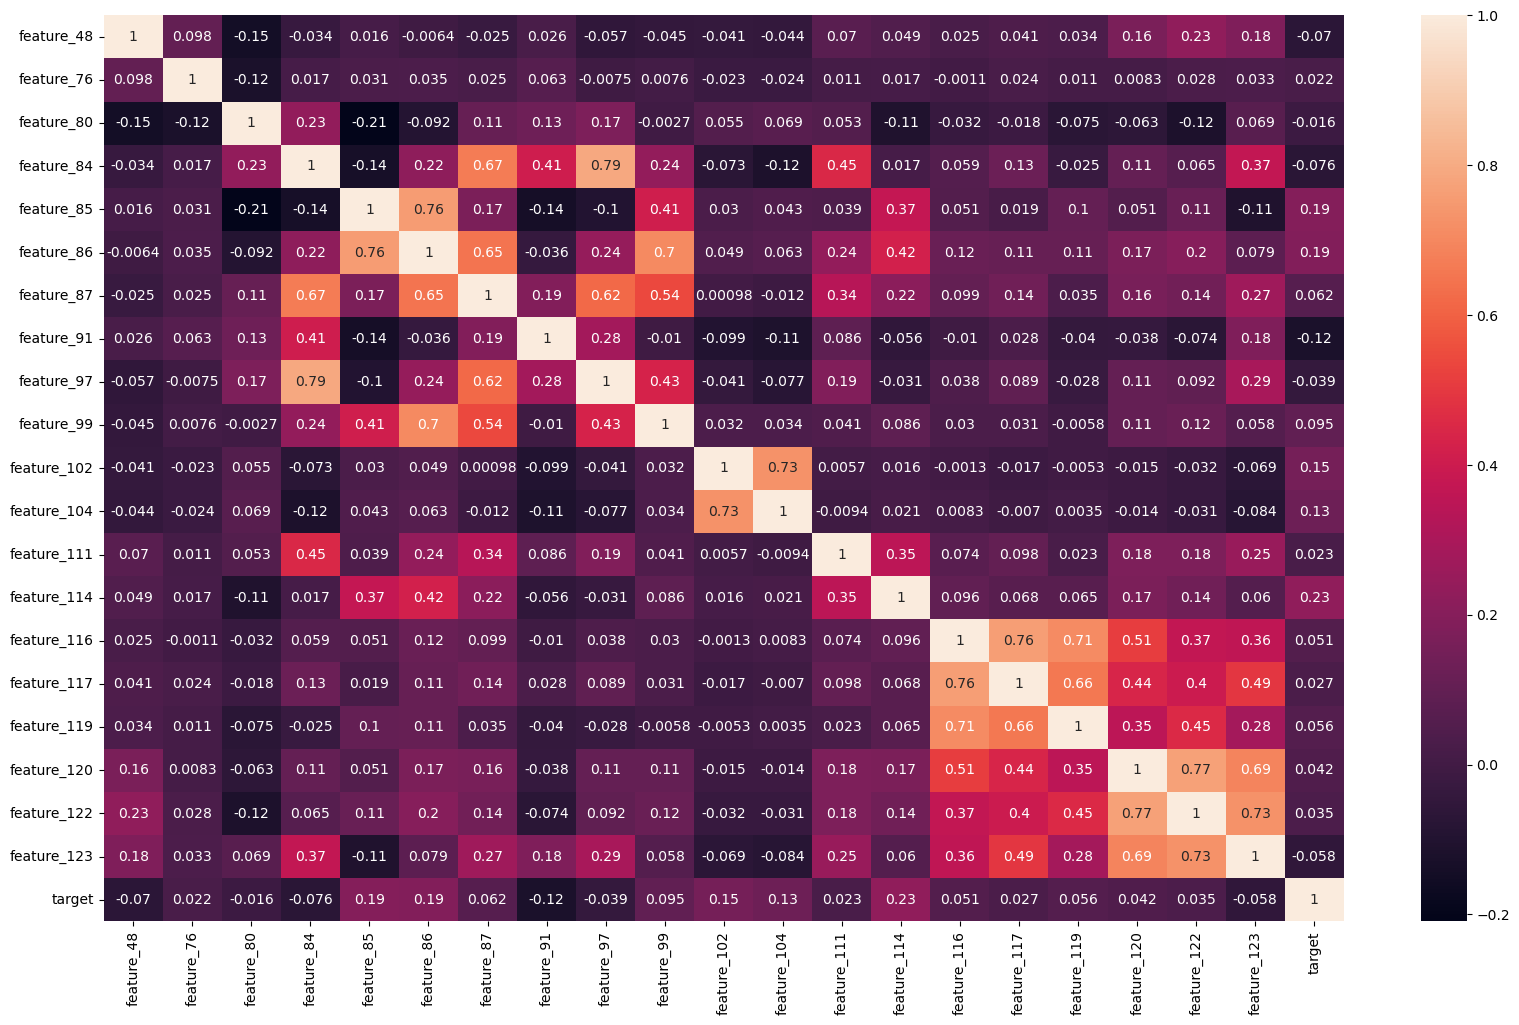

In [34]:
plt.figure(figsize=(20,12), dpi=100)
sns.heatmap(data=df.drop(['is_test', 'ID'], axis=1).corr(), annot=True);

На графиках ниже, видны выбросы у некотрых признаков. Это может быть аномалией. Но из за недостатка данных по признакам сложно судить. Это может быть и нормой. Необходимо больше информации о данных.

Можно было бы их к примеру заменить.

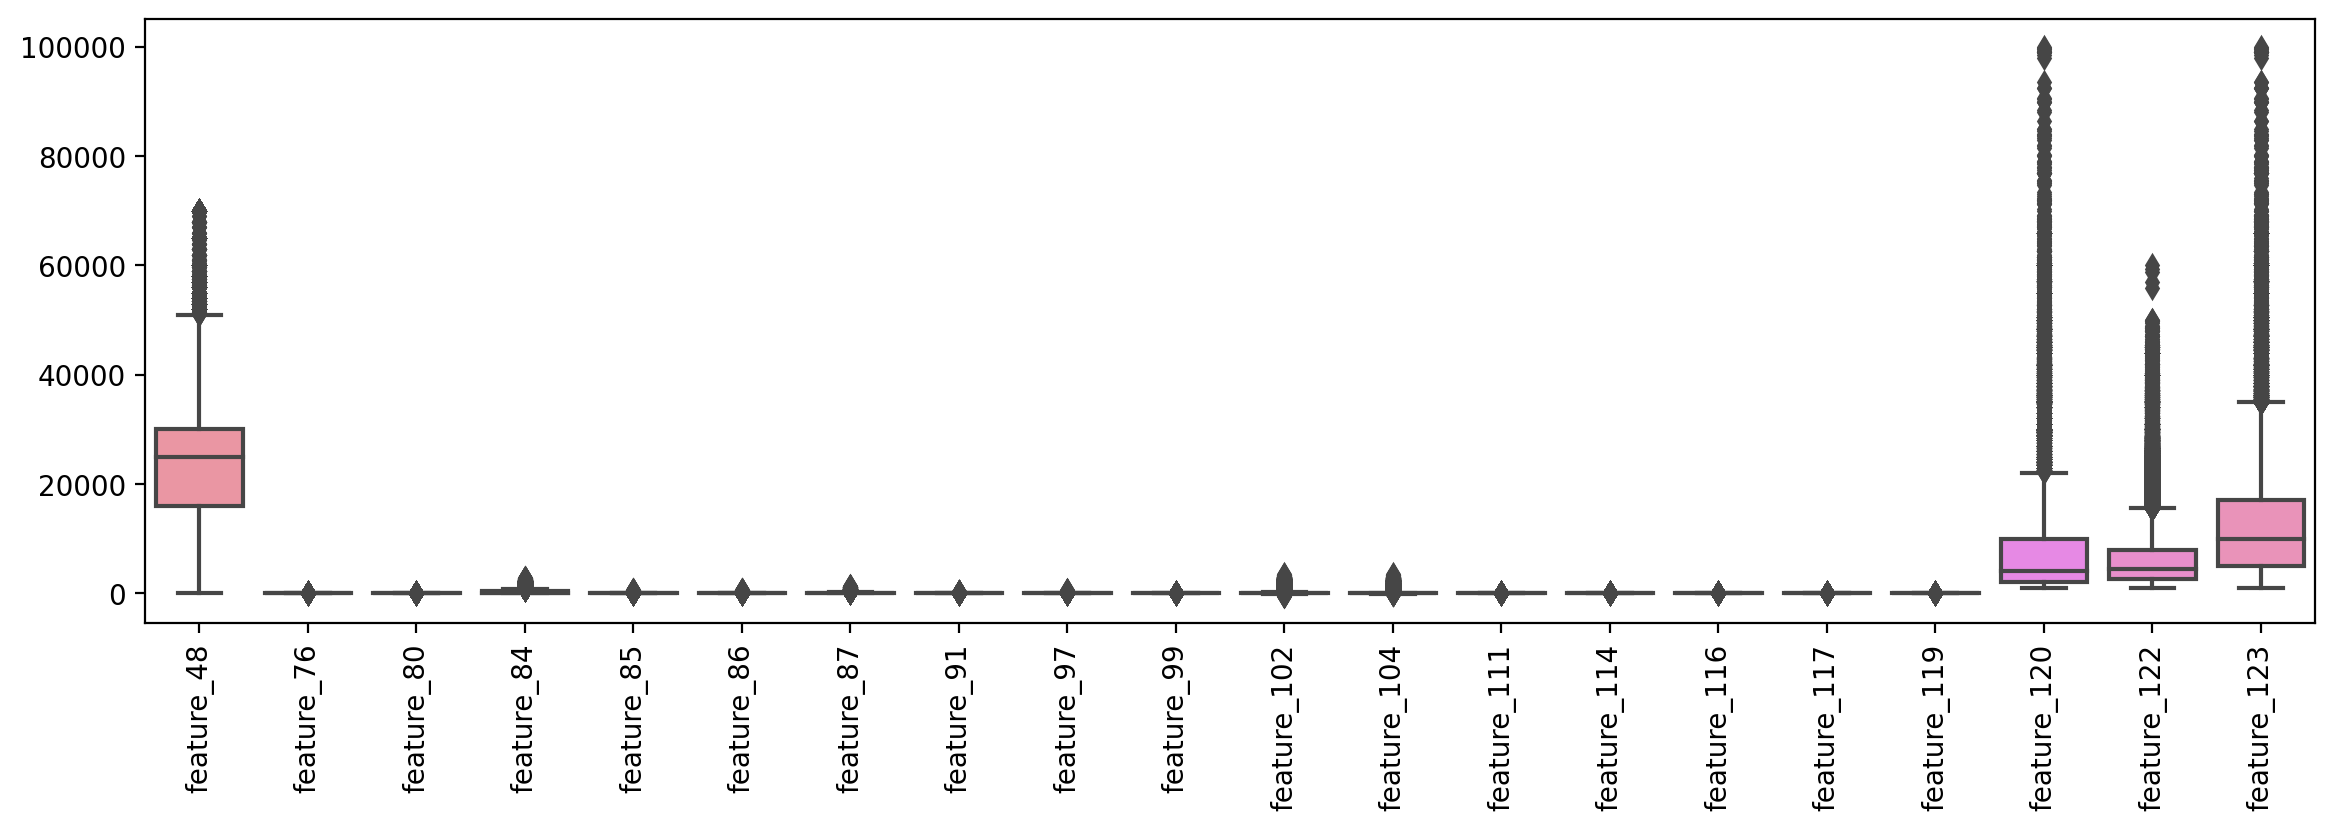

In [35]:
plt.figure(figsize=(14,4),dpi=200)
sns.boxplot(data=df.drop(['is_test','target', 'ID'], axis=1))
plt.xticks(rotation=90);

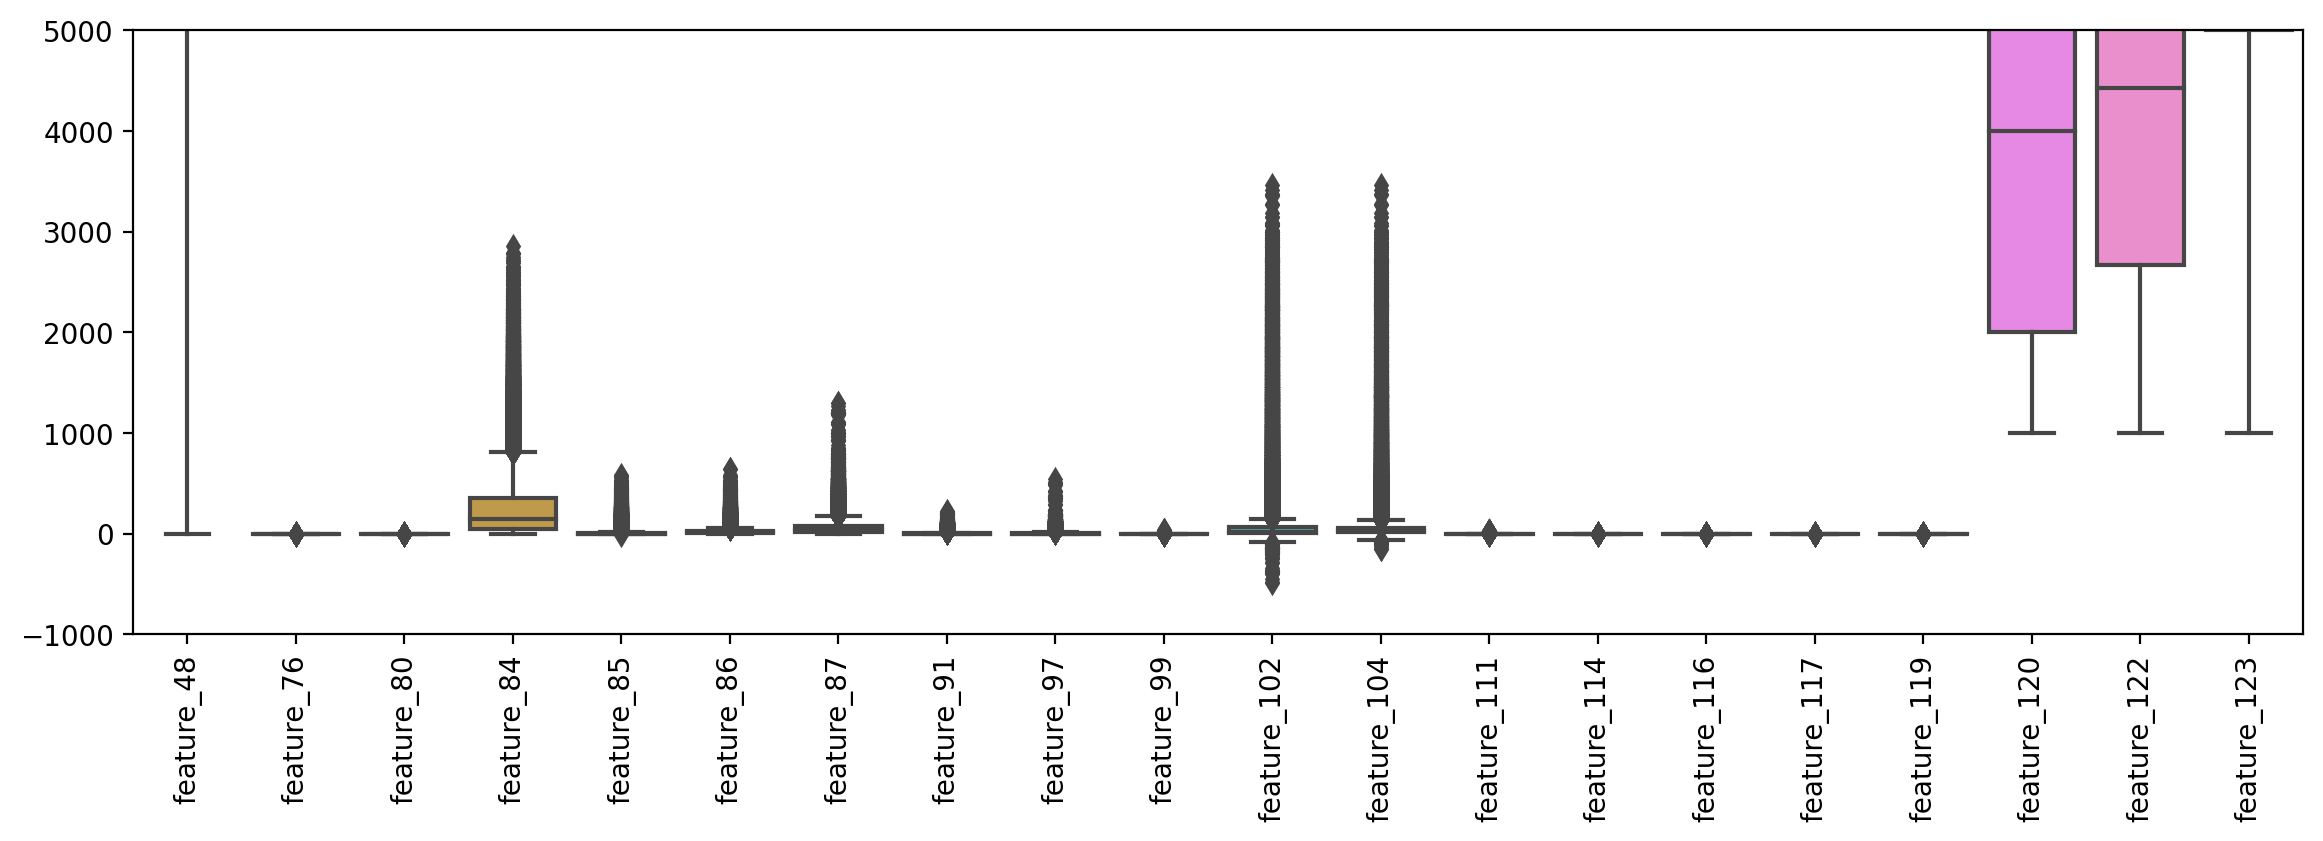

In [36]:
plt.figure(figsize=(14,4),dpi=200)
sns.boxplot(data=df.drop(['is_test','target', 'ID'], axis=1))
plt.xticks(rotation=90)
plt.ylim(-1000,5000);

Удаляем признак ID, т к он просто дублирует index.

In [37]:
ID_test = df[df['is_test']==1]['ID']

In [38]:
df = df.drop('ID', axis=1)

### Подготовка данных и стандартизация.

In [39]:
X = df[df['is_test']==0].drop(['is_test','target'], axis=1)

y = data['target']

test = df[df['is_test']==1].drop(['is_test', 'target'], axis=1)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [42]:
scaler = StandardScaler()

In [43]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Логистическая модель с перекрестной проверкой.

In [44]:
from sklearn.linear_model import LogisticRegressionCV

In [45]:
log_model = LogisticRegressionCV(class_weight='balanced', max_iter=5000, cv=5)

In [46]:
log_model.fit(scaled_X_train,y_train)

LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=5000)

In [47]:
log_model.C_

array([0.0001])

In [48]:
log_model.get_params()

{'Cs': 10,
 'class_weight': 'balanced',
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

### Важные признаки.

In [49]:
log_model.coef_

array([[-0.14272829,  0.01742811,  0.06168549, -0.13168691,  0.11243455,
         0.10484261,  0.05494228, -0.22869426,  0.03696454,  0.04231163,
         0.23095274,  0.10759944, -0.03880626,  0.31013097,  0.04573465,
         0.02549051,  0.02852043,  0.06016481,  0.04331117, -0.1582063 ]])

In [50]:
coefs = pd.Series(index=X.columns,data=log_model.coef_[0])

In [51]:
coefs = coefs.sort_values()

In [52]:
coefs.index[0:124]

Index(['feature_91', 'feature_123', 'feature_48', 'feature_84', 'feature_111',
       'feature_76', 'feature_117', 'feature_119', 'feature_97', 'feature_99',
       'feature_122', 'feature_116', 'feature_87', 'feature_120', 'feature_80',
       'feature_86', 'feature_104', 'feature_85', 'feature_102',
       'feature_114'],
      dtype='object')

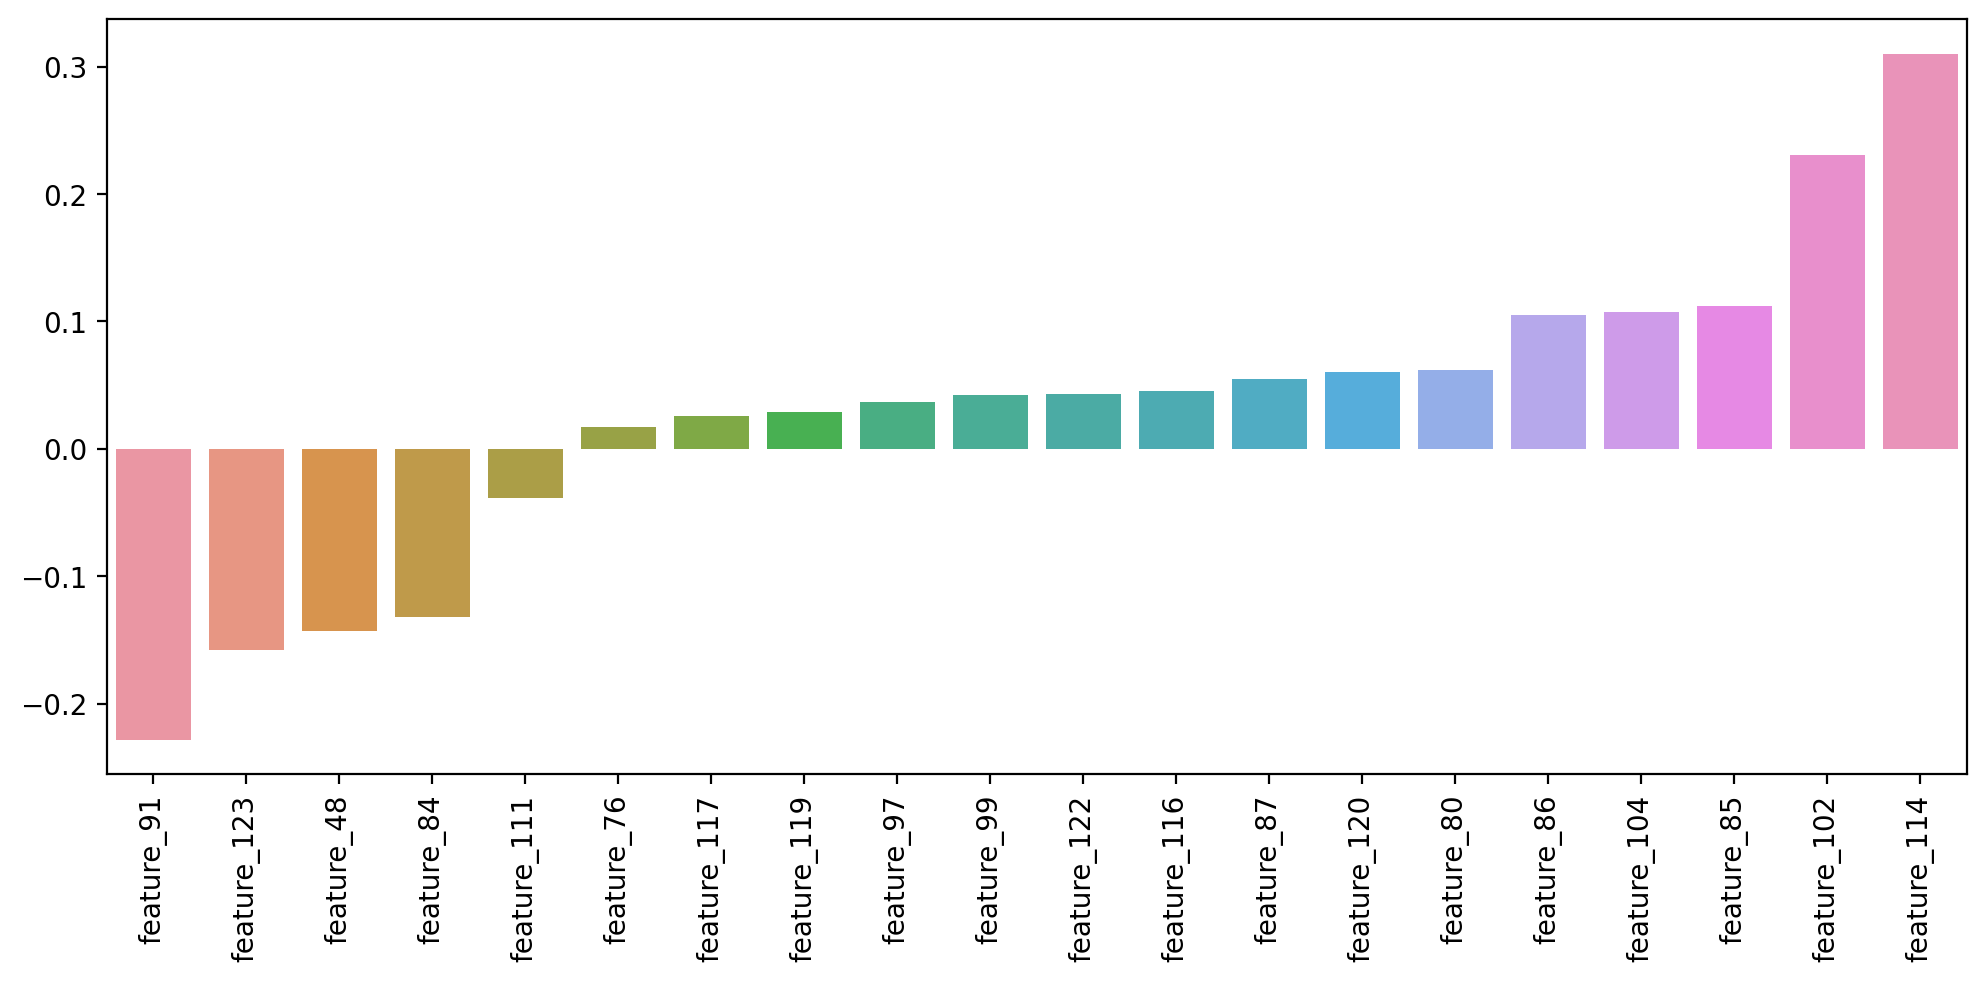

In [53]:
plt.figure(figsize=(12,5), dpi=200)
sns.barplot(x=coefs.index,y=coefs.values);
plt.xticks(rotation=90);

In [54]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [55]:
y_pred = log_model.predict(scaled_X_test)

### Вероятность полученного прогноза на обучающей выборке.

In [56]:
predictions = log_model.predict_proba(scaled_X_test)

In [57]:
predictions

array([[0.50774323, 0.49225677],
       [0.53044084, 0.46955916],
       [0.50771195, 0.49228805],
       ...,
       [0.66089603, 0.33910397],
       [0.30610985, 0.69389015],
       [0.48940741, 0.51059259]])

In [58]:
log_model.coef_

array([[-0.14272829,  0.01742811,  0.06168549, -0.13168691,  0.11243455,
         0.10484261,  0.05494228, -0.22869426,  0.03696454,  0.04231163,
         0.23095274,  0.10759944, -0.03880626,  0.31013097,  0.04573465,
         0.02549051,  0.02852043,  0.06016481,  0.04331117, -0.1582063 ]])

In [59]:
tab = pd.DataFrame(data=predictions[:,1], columns=['Кол_во_target_1'])

In [60]:
tab['Всего_в_группе'] = 1

In [61]:
def cohort(Кол_во_target_1):
    if Кол_во_target_1 < 0.1:
        return '0.0 - 0.1'
    elif Кол_во_target_1 < 0.2:
        return '0.1 - 0.2'
    elif Кол_во_target_1 < 0.3:
        return '0.2 - 0.3'
    elif Кол_во_target_1 < 0.4:
        return '0.3 - 0.4'
    elif Кол_во_target_1 < 0.5:
        return '0.4 - 0.5'
    elif Кол_во_target_1 < 0.6:
        return '0.5 - 0.6'
    elif Кол_во_target_1 < 0.7:
        return '0.6 - 0.7'
    elif Кол_во_target_1 < 0.8:
        return '0.7 - 0.8'
    elif Кол_во_target_1 < 0.9:
        return '0.8 - 0.9'
    else:
        return "0.9 - 1.0"

In [62]:
tab['Вероятность'] = tab['Кол_во_target_1'].apply(cohort)

In [63]:
tab.groupby('Вероятность').agg({'Всего_в_группе':['count'],'Кол_во_target_1':['sum']}).astype('int64')

,Всего_в_группе,Кол_во_target_1
,count,sum
Вероятность,,
0.0 - 0.1,279,18
0.1 - 0.2,1358,219
0.2 - 0.3,5230,1365
0.3 - 0.4,17460,6252
0.4 - 0.5,30231,13593
0.5 - 0.6,12235,6553
0.6 - 0.7,3615,2340
0.7 - 0.8,3384,2531


### Оценка классификатора (точность, полнота, F-мера)

In [64]:
confusion_matrix(y_test,y_pred)

array([[48030, 13596],
       [ 6528,  8592]], dtype=int64)

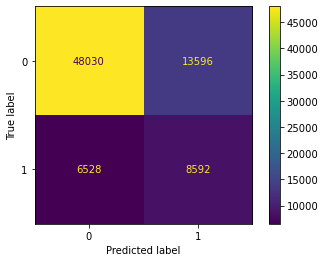

In [65]:
plot_confusion_matrix(log_model,scaled_X_test,y_test)

In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     61626
           1       0.39      0.57      0.46     15120

    accuracy                           0.74     76746
   macro avg       0.63      0.67      0.64     76746
weighted avg       0.78      0.74      0.75     76746



### ROC-анализ

In [67]:
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve

Интервал AUC Качество модели

0,9-1,0	Отличное

0,8-0,9	Очень хорошее

0,7-0,8	Хорошее

0,6-0,7	Среднее

0,5-0,6	Неудовлетворительное

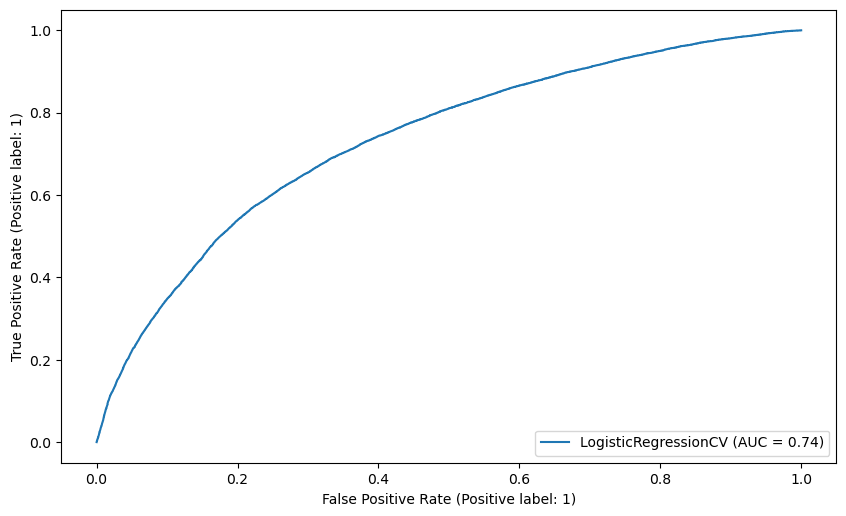

In [68]:
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
plot_roc_curve(log_model,scaled_X_test,y_test,ax=ax)

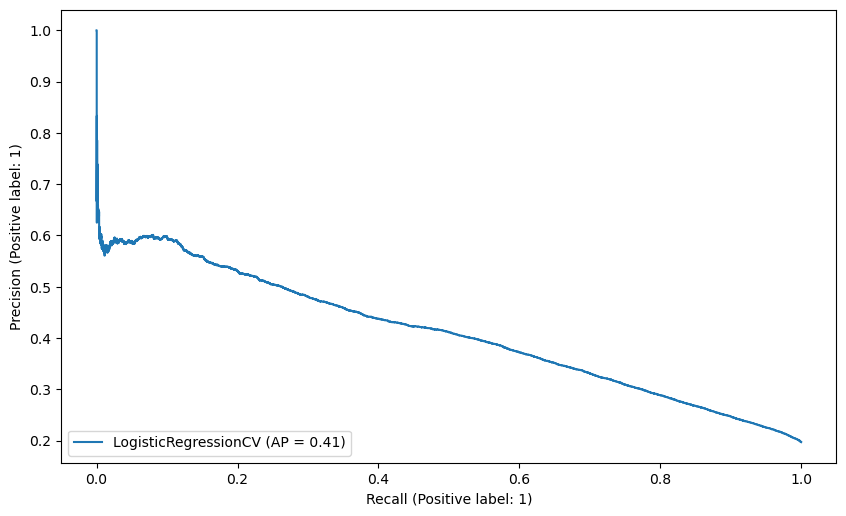

In [69]:
fig,ax = plt.subplots(figsize=(10,6),dpi=100)
plot_precision_recall_curve(log_model,scaled_X_test,y_test, ax=ax)

### Предсказание для тестового набора целевого значения target.

In [70]:
test = test.reset_index(drop=True)

In [71]:
scaled_test = scaler.fit_transform(test)

In [72]:
test['target'] = log_model.predict(scaled_test)

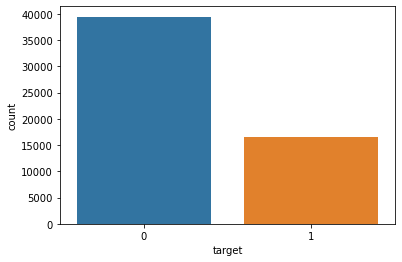

In [73]:
sns.countplot(data=test, x='target');

In [74]:
print("Процент target = 0:")
round(len(test[test['target']==0]) / len(test),2)

Процент target = 0:


0.7

In [75]:
print("Процент target = 0:")
round(len(test[test['target']==1]) / len(test),2)

Процент target = 0:


0.3

### Вероятность полученного предсказания.

In [76]:
predictions_test = log_model.predict_proba(scaled_test)

In [77]:
predictions_test

array([[0.82037574, 0.17962426],
       [0.48705281, 0.51294719],
       [0.42533862, 0.57466138],
       ...,
       [0.62089481, 0.37910519],
       [0.60573628, 0.39426372],
       [0.47086121, 0.52913879]])

In [78]:
target_one = pd.DataFrame(data=predictions_test[:,1])

In [79]:
ID_test = ID_test.reset_index(drop=True)

In [80]:
submission_df = pd.concat([ID_test,target_one],axis=1)

In [81]:
submission_df['ID;score'] = submission_df['ID'].astype(str) +";"+ submission_df[0].astype(str)

In [82]:
submission_df = submission_df['ID;score']

In [83]:
submission_df.to_csv('submission.csv', index=False)

In [84]:
submission_df = pd.read_csv('submission.csv')

In [85]:
submission_df

,ID;score
0,255821;0.17962426124751438
1,255822;0.5129471932823207
2,255823;0.5746613817385157
3,255824;0.3131891316814028
4,255825;0.5307384088750491
...,...
56025,311846;0.41327195636460307
56026,311847;0.3608596342095482
56027,311848;0.3791051875781926
56028,311849;0.39426371822790623


---
---